In [ ]:
# K-Modes
from kmodes.kmodes import KModes

# DBSCAN
from sklearn.cluster import DBSCAN
# ROCK
from pyclustering.cluster.rock import rock


# Para visualização e manipulação 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import umap
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform


# Para avaliçãp
from sklearn.metrics import accuracy_score

c:\Users\maype\Desktop\projetos\Trabalho Prático AM2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Visualizando os clusters gerados pelos diferentes modelos
def plot_clusters(data, labels, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='Spectral', s=30, alpha=0.7)
    plt.colorbar(label='Clusters')
    plt.title(title)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

In [2]:
fatores_df = pd.read_csv(r'C:\Users\maype\Desktop\projetos\Trabalho Prático AM2\data\base_fatores.csv')

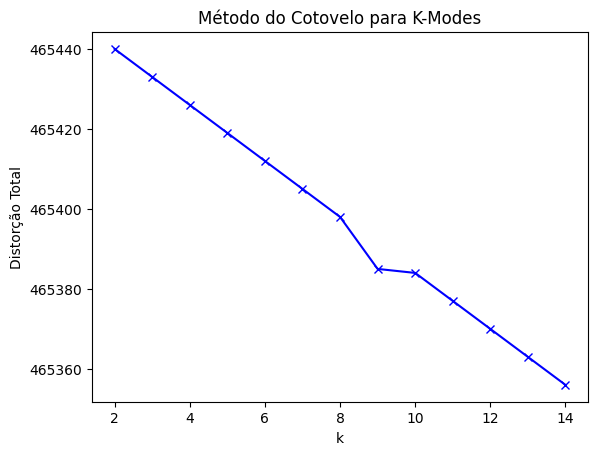

In [4]:
distortions = []
K = range(2, 15) # Testando de 2 a 5 clusters

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)  # 'Huang' é um método de inicialização
    clusters = km.fit_predict(fatores_df)
    distortion = km.cost_ # Distância total (atributo já existente na biblioteca kmodes)
    distortions.append(distortion)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorção Total')
plt.title('Método do Cotovelo para K-Modes')
plt.show()

In [5]:
# K-Modes
k_modes = KModes(n_clusters=9, init='Huang', n_init=10, verbose=1)
clusters_kmodes = k_modes.fit_predict(fatores_df.drop('diagnostico_hipertensao', axis=1))

# Adicionando os resultados ao DataFrame
fatores_df['cluster_kmodes'] = clusters_kmodes


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 465397.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, ite

In [15]:
# Importando fatores gerados pelo UMAP 
fatores_umap_df = pd.read_csv(r'C:\Users\maype\Desktop\projetos\Trabalho Prático AM2\data\fatores_umap.csv')

# Binarização dos dados categóricos
fatores_umap_binarizado = pd.get_dummies(fatores_umap_df)

# Convertendo o DataFrame para um array NumPy
fatores_umap_binarizado_array = fatores_umap_binarizado.values

# Calcula a matriz de distâncias de Jaccard
dist_matrix_jaccard = pairwise_distances(fatores_umap_binarizado_array, metric='jaccard')

# Ajuste do eps com base no UMAP
valores_eps = [0.5, 1, 1.5, 2]  # Teste diferentes valores de eps

for eps in valores_eps:
    # Usando a matriz de distância pré-computada
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='precomputed')
    clusters_dbscan = dbscan.fit_predict(dist_matrix_jaccard)

    # Função de visualização dos clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(fatores_umap_df.iloc[:, 0], fatores_umap_df.iloc[:, 1], c=clusters_dbscan, cmap='Spectral', s=30, alpha=0.7)
    plt.colorbar(label='Clusters')
    plt.title(f'Clusters DBSCAN (eps={eps}) com UMAP e Jaccard')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

c:\Users\maype\Desktop\projetos\Trabalho Prático AM2\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


MemoryError: Unable to allocate 32.9 GiB for an array with shape (66496, 66496) and data type float64

In [17]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste eps e min_samples conforme necessário
clusters_dbscan = dbscan.fit_predict(fatores_df.drop('diagnostico_hipertensao', axis=1))

# Adicionando os resultados ao DataFrame
fatores_df['cluster_dbscan'] = clusters_dbscan


In [ ]:
# Remover a coluna de diagnóstico para o clustering
fatores_df_sem_diagnostico = fatores_df.drop('diagnostico_hipertensao', axis=1)

# Convertendo para formato numérico adequado ao pyclustering
# Transformamos os dados categóricos em números usando 'astype('category').cat.codes'
fatores_numericos = fatores_df_sem_diagnostico.apply(lambda x: x.astype('category').cat.codes).values.tolist()

# Instanciando o algoritmo ROCK
rock_instance = rock(fatores_numericos, eps=0.5, number_clusters=3, threshold=0.5)
rock_instance.process()

# Obtendo os clusters
clusters_rock = rock_instance.get_clusters()

# Reduzindo a dimensionalidade para visualização com UMAP
umap_2d = umap.UMAP(n_components=2, random_state=42)
fatores_umap = umap_2d.fit_transform(fatores_df_sem_diagnostico)

# Mapeando os clusters no formato esperado
cluster_labels = [-1] * len(fatores_numericos)
for cluster_id, cluster_points in enumerate(clusters_rock):
    for point_index in cluster_points:
        cluster_labels[point_index] = cluster_id

In [ ]:
# Aplicando UMAP para reduzir os fatores a 2 dimensões
umap_2d = umap.UMAP(n_components=2, random_state=42)
fatores_umap = umap_2d.fit_transform(fatores_sem_diagnostico)

# Plotando clusters gerados
#plot_clusters(fatores_umap, clusters_rock, 'Clusters ROCK com UMAP')
plot_clusters(fatores_umap, clusters_kmodes, 'Clusters K-Modes com UMAP')
plot_clusters(fatores_umap, clusters_dbscan, 'Clusters DBSCAN com UMAP')

In [ ]:
# Médias dos fatores por cluster (K-Modes como exemplo)
cluster_analysis_kmodes = fatores_df.groupby('cluster_kmodes').mean()
print(cluster_analysis_kmodes)

# Para DBSCAN
cluster_analysis_dbscan = fatores_df.groupby('cluster_dbscan').mean()
print(cluster_analysis_dbscan)

# Para Rock
#cluster_analysis_rock = fatores_df.groupby('cluster_rock').mean()
#print(cluster_analysis_rock)

In [ ]:
def calcular_pureza(y_true, clusters):
    contingency_matrix = pd.crosstab(y_true, clusters)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Pureza para K-Modes
pureza_kmodes = calcular_pureza(fatores_df['diagnostico_hipertensao'], clusters_kmodes)
print(f'Pureza K-Modes: {pureza_kmodes}')

# Pureza para DBSCAN
pureza_dbscan = calcular_pureza(fatores_df['diagnostico_hipertensao'], clusters_dbscan)
print(f'Pureza DBSCAN: {pureza_dbscan}')

# Pureza para Rock
#pureza_rock = calcular_pureza(fatores_df['diagnostico_hipertensao'], clusters_rock)
#print(f'Pureza Aglomerativo: {pureza_rock}')